In [1]:
# import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [8]:
root = '/content/drive/MyDrive/dataset/u_net_data/aerial_dataset'
def load_dataset(root, img_size=(128,128)):
  images,masks = [],[]
  for tile in sorted(os.listdir(root)):
    img_dir = os.path.join(root,tile,'images')
    mask_dir = os.path.join(root,tile,'masks')
    if not os.path.exists(img_dir):
      continue
    for f in os.listdir(img_dir):
      img_path = os.path.join(img_dir,f)
      mask_path = os.path.join(mask_dir,os.path.splitext(f)[0] + ".png")
      if not os.path.exists(mask_path):
        continue


      img = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
      img = cv2.resize(img,img_size)/255.0

      mask = cv2.cvtColor(cv2.imread(mask_path),cv2.COLOR_BGR2GRAY)
      mask = cv2.resize(mask,img_size)
      mask = np.expand_dims(mask,axis=-1)
      mask = mask/255.0

      images.append(img)
      masks.append(mask)
  return np.array(images,dtype="float32"),np.array(masks,dtype="float32")

X, y = load_dataset(root, img_size=(128, 128))
print(f"Toplam ornek: {len(X)}") # toplam veri sayisi

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
print(f"Toplam train ornek: {len(X_train)}") # toplam veri sayisi
print(f"Toplam test ornek: {len(X_val)}") # toplam veri sayisi




Toplam ornek: 72
Toplam train ornek: 57
Toplam test ornek: 15


In [10]:
def unet_model(input_size = (128, 128, 3)):

    inputs = keras.Input(input_size) # girdi katmani

    # encoder: feature extraction ve downsampling
    c1 = layers.Conv2D(16, 3, activation = "relu", padding = "same")(inputs) # 16 filtre 3x3 kernel
    c1 = layers.Conv2D(16, 3, activation = "relu", padding = "same")(c1)
    p1 = layers.MaxPooling2D()(c1) # downsampling 64x64

    c2 = layers.Conv2D(32, 3, activation = "relu", padding = "same")(p1)
    c2 = layers.Conv2D(32, 3, activation = "relu", padding = "same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation = "relu", padding = "same")(p2)
    c3 = layers.Conv2D(64, 3, activation = "relu", padding = "same")(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(128, 3, activation = "relu", padding = "same")(p3)
    c4 = layers.Conv2D(128, 3, activation = "relu", padding = "same")(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottlenech: en derin seviye
    c5 = layers.Conv2D(256, 3, activation = "relu", padding = "same")(p4)
    c5 = layers.Conv2D(256, 3, activation = "relu", padding = "same")(c5)

    # decoder: up sampling ve skip connection
    u6 = layers.Conv2DTranspose(128, 2, strides = (2,2), padding = "same")(c5) # up sample 8x8 -> 16x16
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, 3, activation = "relu", padding = "same")(u6)
    c6 = layers.Conv2D(128, 3, activation = "relu", padding = "same")(c6)

    u7 = layers.Conv2DTranspose(64, 2, strides = (2,2), padding = "same")(c6) # 16 -> 32
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, 3, activation = "relu", padding = "same")(u7)
    c7 = layers.Conv2D(64, 3, activation = "relu", padding = "same")(c7)

    u8 = layers.Conv2DTranspose(32,2,strides = (2,2), padding = "same")(c7) # 32 -> 64
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, 3, activation = "relu", padding = "same")(u8)
    c8 = layers.Conv2D(32, 3, activation = "relu", padding = "same")(c8)

    u9 = layers.Conv2DTranspose(16, 2, strides = (2,2), padding = "same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16,3,activation = "relu", padding = "same")(u9)
    c9 = layers.Conv2D(16,3, activation = "relu", padding = "same")(c9)

    outputs = layers.Conv2D(1,1,activation = "sigmoid")(c9)

    return keras.Model(inputs, outputs)

unet_model = unet_model()
unet_model.compile(optimizer="adam", loss = "binary_crossentropy")

# callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("model_best.h5", save_best_only = True), # en iyi modeli kaydet
    keras.callbacks.ReduceLROnPlateau(), # dogrulama kaybi dusmez ise learning rate i azalt
    keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True) # 10 epoch boyunca iyilesmez ise durdur
]


history = unet_model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val), # dogrulama verisi
    epochs = 10,
    batch_size = 16,
    callbacks = callbacks
)



Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6939

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.6938 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6901

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.6899 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6840

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 0.6841 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6851

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.6852 - val_loss: 0.6772 - learning_rate: 0.0010
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6783

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.6786 - val_loss: 0.6768 - learning_rate: 0.0010
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6772

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.6772 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6762

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.6759 - val_loss: 0.6727 - learning_rate: 0.0010
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6697

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 0.6694 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.6646 - val_loss: 0.6967 - learning_rate: 0.0010
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6658

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.6654 - val_loss: 0.6605 - learning_rate: 0.0010


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


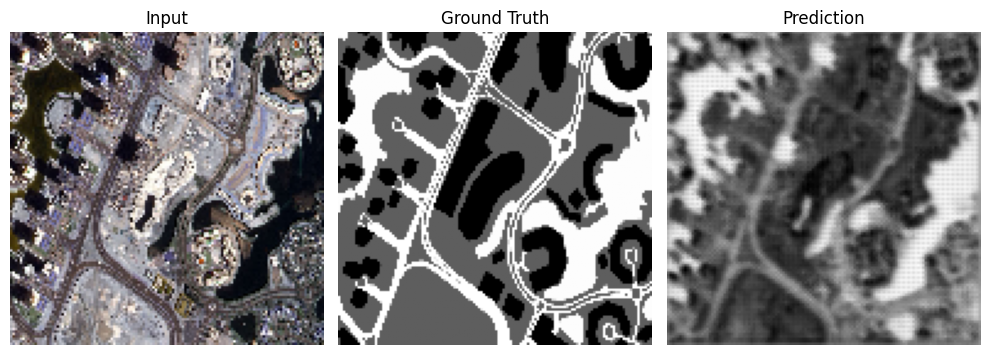

In [11]:
def show_prediction(idx = 0):
    img = X_val[idx]
    mask_true = y_val[idx].squeeze() # gercek maske
    pred_raw = unet_model.predict(img[None, ...])[0].squeeze() # modelden tahmini al ve kanali sıkıstır
    mask_pred = (pred_raw > 0.5).astype("float32") # 0.5 esik degeri ile 2 li maske olustur

    # sonuclari gorsellestir
    plt.figure(figsize = (10,4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(mask_true, cmap= "gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_raw, cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

show_prediction(1)